In [1]:
import os, sys 
class ut: 
    def __init__(self): pass 
    
    _active = True 
    def verbose(flag, long_content, func_dir=""): 
        # ut._active = flag 
        if(ut._active==False): return 
        print("__verbose__:", func_dir, flush=True) 
        print(long_content, flush=True) 

    def note_verbose(flag, title, func_dir=""): 
        # ut._active = flag 
        ut.mess() 
        if(ut._active==False): return 
        print("__verbose__:", func_dir, "@@@", title, flush=True) 
    
    def mess(*mess):
        if(ut._active==False): return 
        print(*mess, flush=True)
    
    def over(val, var_name=""): 
        if(ut._active==False): return 
        try: ut.mess("__var_name__:", var_name + "\n", (type(val), val.shape, str(sys.getsizeof(val)) + "Bytes"))
        except Exception as e:  
            ut.mess("__var_name__:", var_name + "\n", (type(val), "no-shape", str(sys.getsizeof(val)) + "Bytes"))
    
import numpy as np 
import cv2
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from skimage.feature import hog
import pandas as pd 
class Imops:  
    def __init__(self, mode="RGB", image_size: tuple=None, scale_const: float=None):
        self.class_name = "Imops"
        if(mode[0].upper() == "R"): mode = "RGB"
        else: mode = "WB"
        self._mode, self._size, self._scale_const = mode, image_size, scale_const 
    
    def load_image_from_file(self, file_dir): 
        gray_mode = (self._mode == "WB")
        image = self.read_image(file_dir, gray_mode=gray_mode)
        if(self._size!=None):
            image = self.resize_image(image=image, size=self._size) 
        if(self._scale_const!=None):
            image = self.scale_image(image=image, scale_const=self._scale_const) 
        ut.note_verbose(True, "load image full", self.class_name +  " > self.load_image_from_file()") 
        ut.over(image, "return image") 
        return image 
        
    def read_image(self, image_dir, gray_mode=False): 
        '''
        - read image from file_dir
        - if gray_mode, will read WB image else will read RGB image 
        '''
        mode = 'WB'
        img = cv2.imread(image_dir, 0) 
        if(gray_mode==False): 
            img = cv2.imread(image_dir) 
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            mode = 'RGB'
        ut.note_verbose(True, "read iamge {} full".format(mode), self.class_name + " > read_image()") 
        ut.over(img, "return image") 
        return img 

    def plot_image(self, image): 
        '''
        - plot image 
        '''
        plt.imshow(image)
        plt.axis('off')  # Turn off axis
        plt.show()
        
    def rgb2wb(self, image): 
        '''
        - convert rgb image to wb iamge 
        '''
        wb_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        ut.note_verbose(True, "convert RGB to WB", self.class_name + " > rgb2wb()")
        ut.over(wb_image, "return wb_image")
        return wb_image 
    
    def extract_histogram_from_image(self, wb_image): 
        '''
        - extract histogram feature from image 
        '''
        image = wb_image 
        histogram = cv2.calcHist([image.flatten()], channels=[0], mask=None, histSize=[256], ranges=[0, 256])
        histogram /=  image.flatten().shape[0]
        ut.note_verbose(True, "extract histogram", self.class_name + " > extract_histogram__()")
        ut.over(histogram, "return histogram")
        return histogram 

    def plot_histogram_of_image(self, wb_image): 
        '''
        - compute and plot histogram of wb_image 
        '''
        image = wb_image 
        histogram = cv2.calcHist([image.flatten()], channels=[0], mask=None, histSize=[256], ranges=[0, 256])
        #* normalize histogram 
        histogram /=  image.flatten().shape[0]
        #* plot the histogram
        ut.note_verbose(True, "total of pixels is {}".format(len(image.flatten())), self.class_name +  " > self.plot_histogram_of_image()")
        plt.plot(histogram, color='black')
        plt.xlabel('Pixel Intensity')
        plt.ylabel('Frequency')
        plt.title('Histogram of Image')
        plt.show()
    
    def solbel_image_from_image(self, wb_image): 
        '''
        - compute solbel image from image 
        '''
        image = wb_image 
        Sx = np.array([[-1,0,1], [-2,0,2], [-1,0,1]], np.float64)
        Sy = np.array([[1,2,1], [0,0,0], [-1,-2,-1]], np.float64)
        Ix = cv2.filter2D(image, -1, Sx)
        Iy = cv2.filter2D(image, -1, Sy)
        G = np.hypot(Ix,Iy)
        G = G/G.max()*255
        theta = np.arctan2(Iy,Ix)
        ut.note_verbose(True, "solbel image", self.class_name + " > solbel_image__()")
        ut.over(G, "return solbel image")
        return G 
    
    def extract_sobel_feature_from_image(self, wb_image): 
        '''
        - extract sobel sum feature from image 
        '''
        img = cv2.resize(wb_image, (256, 256))
        _, _, G, _ = self.sobel_filters(img)
        #* combine the sum following Ox and Oy 
        row_sum = np.sum(G, axis=1, dtype=np.float64)
        col_sum = np.sum(G, axis=0, dtype=np.float64)
        fea = np.hstack((row_sum.T, col_sum))
        ut.note_verbose(True, "solbel feature", self.class_name + " > extract_solbel_feature__()")
        ut.over(fea, "return solbel feature")
        return (fea)
    
    def compute_distance_simular(self, train_mtr, test_mtr, metric: str): 
        '''
        - compute distance simular of 2 matrix (train, test)
        '''
        if(metric[0].upper() == 'C'): metric = 'cosine'
        elif(metric[0].upper() == 'E'): metric = 'euclidean'
        dis = cdist(test_mtr, train_mtr, metric=metric) 
        ut.note_verbose(True, "distance of two matrix", self.class_name + " > compute_distance__()")
        ut.over(dis, "return distance matrix") 
        return dis 
    
    def resize_image(self, image, size=(256, 256)): 
        '''
        - resize (w, h) of image 
        '''
        resize_image = cv2.resize(image, size)
        ut.note_verbose(True, "resize {} image".format(size), self.class_name + " > resize_image()")
        ut.over(resize_image, "return resize image") 
        return resize_image 
    
    def scale_image(self, image, scale_const=255): 
        '''
        - scale image to ... 
        '''
        scale_image = image/scale_const
        ut.note_verbose(True, "scale image /{}".format(scale_const), self.class_name + " > scale_image()")
        ut.over(scale_image, "return scale image") 
        return scale_image 
    
    def extract_hog_feature_from_image(self, rgb_image): 
        '''
        - extract hog feature from image 
        '''
        gray_image = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2GRAY)
        hog_fea, _ = hog(gray_image, orientations=8, pixels_per_cell=(8, 8),
                                cells_per_block=(1, 1), visualize=True, multichannel=False)
        ut.note_verbose(True, "hog feature", self.class_name + " > extract_hog_feature__()")
        ut.over(hog_fea, "return hog feature") 
        return hog_fea 
    
    def hog_image_from_image(self, rgb_image): 
        '''
        - compute hog image from image 
        '''
        gray_image = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2GRAY)
        _, hog_image = hog(gray_image, orientations=8, pixels_per_cell=(8, 8),
                                cells_per_block=(1, 1), visualize=True)
        ut.note_verbose(True, "hog image", self.class_name + " > hog_image__()")
        ut.over(hog_image, "return hog image") 
        return hog_image
    
    def equalize_image(self, image, tile_size: tuple=None): 
        '''
        - apply equali histogram to image 
        '''
        equalized_image = cv2.equalizeHist(image)
        if(tile_size!=None): 
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=tile_size) 
            equalized_image = clahe.apply(image)                    
        
        ut.note_verbose(True, "apply his equalize {}".format(tile_size), self.class_name + " > self.histogram_equali()")
        ut.over(equalized_image, "return equalize image")         
        return equalized_image 
            
class FileOps: 
    def __init__(self) -> None: 
        self.class_name = "FileOps"
    def list_files_from_root_folder(self, start_folder_path): 
        files, info, filenames = [], [], [] 
        for root, _, file_name_list in os.walk(start_folder_path):
            for filename in file_name_list:
                file_path = os.path.join(root, filename)
                parent_folder_name = os.path.basename(os.path.dirname(file_path)) 
                files.append(file_path)
                info.append(parent_folder_name)
                filenames.append(filename) 
        df = pd.DataFrame({'file_path': files, 'folder': info, 'file_name': filenames})
        ut.note_verbose(True, "list all files in the folder", self.class_name + " > self.list_files_from_root_folder()")
        ut.over(df, "return table")   
        return df    

In [2]:
fo = FileOps()
fo.list_files_from_root_folder('/kaggle/input/dataset1/fruits_dataset')


__verbose__: FileOps > self.list_files_from_root_folder() @@@ list all files in the folder
__var_name__: return table
 (<class 'pandas.core.frame.DataFrame'>, (600, 3), '146884Bytes')


,file_path,folder,file_name
0,/kaggle/input/dataset1/fruits_dataset/test/ban...,test,banana_84.xml
1,/kaggle/input/dataset1/fruits_dataset/test/ora...,test,orange_77.xml
2,/kaggle/input/dataset1/fruits_dataset/test/app...,test,apple_91.jpg
3,/kaggle/input/dataset1/fruits_dataset/test/mix...,test,mixed_21.jpg
4,/kaggle/input/dataset1/fruits_dataset/test/ora...,test,orange_83.jpg
...,...,...,...
595,/kaggle/input/dataset1/fruits_dataset/train/or...,train,orange_53.xml
596,/kaggle/input/dataset1/fruits_dataset/train/ba...,train,banana_11.jpg
597,/kaggle/input/dataset1/fruits_dataset/train/or...,train,orange_56.jpg
598,/kaggle/input/dataset1/fruits_dataset/train/ap...,train,apple_59.jpg



__verbose__: Imops > read_image() @@@ read iamge RGB full
__var_name__: return image
 (<class 'numpy.ndarray'>, (538, 960, 3), '1549584Bytes')

__verbose__: Imops > self.load_image_from_file() @@@ load image full
__var_name__: return image
 (<class 'numpy.ndarray'>, (538, 960, 3), '1549584Bytes')


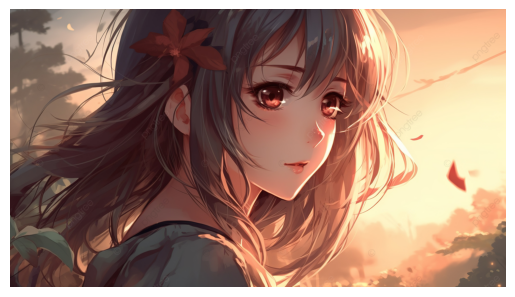

In [3]:
io = Imops()
image = io.load_image_from_file('/kaggle/input/image-beutiful/354986897_1187721651900678_7344377218670918427_n.png')
io.plot_image(image)


__verbose__: Imops > rgb2wb() @@@ convert RGB to WB
__var_name__: return wb_image
 (<class 'numpy.ndarray'>, (538, 960), '516608Bytes')


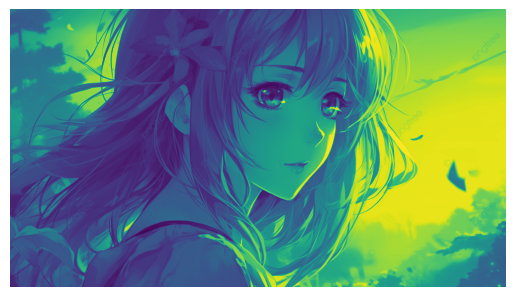

In [4]:
wb_image = io.rgb2wb(image)
io.plot_image(wb_image)


__verbose__: Imops > self.plot_histogram_of_image() @@@ total of pixels is 516480


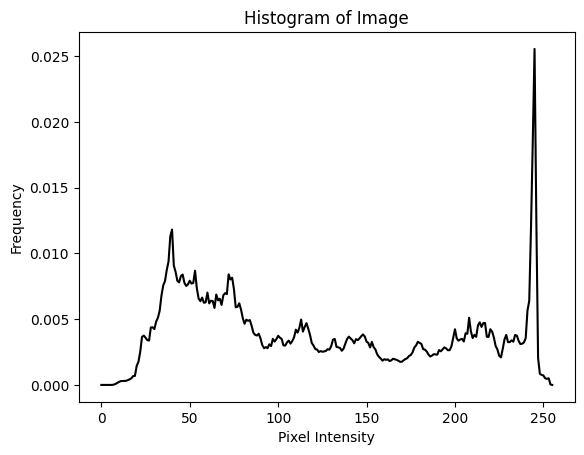

In [5]:
io.plot_histogram_of_image(wb_image)


__verbose__: Imops > solbel_image__() @@@ solbel image
__var_name__: return solbel image
 (<class 'numpy.ndarray'>, (538, 960), '1033088Bytes')


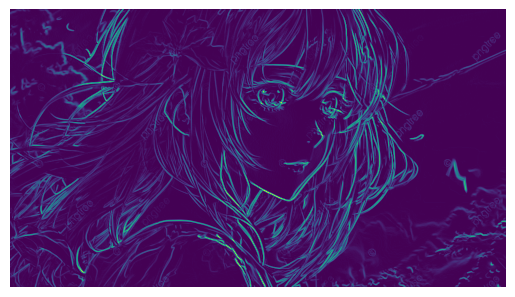

In [6]:
solbel_image = io.solbel_image_from_image(wb_image)
io.plot_image(solbel_image)


__verbose__: Imops > hog_image__() @@@ hog image
__var_name__: return hog image
 (<class 'numpy.ndarray'>, (538, 960), '4131968Bytes')


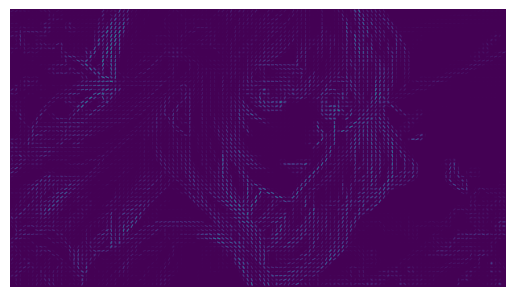

In [7]:
hog_image = io.hog_image_from_image(image)
io.plot_image(hog_image)


__verbose__: Imops > self.histogram_equali() @@@ apply his equalize (4, 4)
__var_name__: return equalize image
 (<class 'numpy.ndarray'>, (538, 960), '516608Bytes')


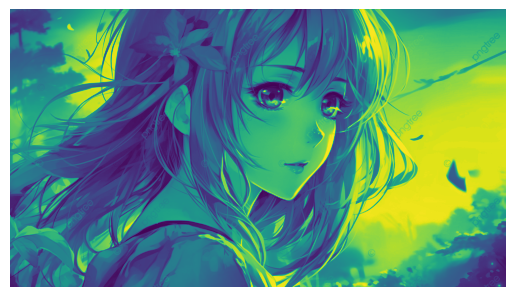

In [8]:
equal_image = io.equalize_image(wb_image, tile_size=(4, 4)) 
io.plot_image(equal_image)


__verbose__: Imops > read_image() @@@ read iamge RGB full
__var_name__: return image
 (<class 'numpy.ndarray'>, (282, 376, 3), '318240Bytes')

__verbose__: Imops > self.load_image_from_file() @@@ load image full
__var_name__: return image
 (<class 'numpy.ndarray'>, (282, 376, 3), '318240Bytes')


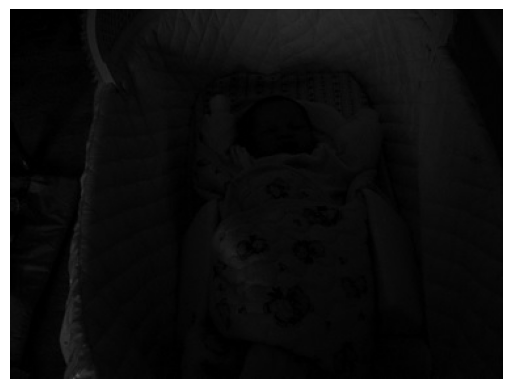


__verbose__: Imops > rgb2wb() @@@ convert RGB to WB
__var_name__: return wb_image
 (<class 'numpy.ndarray'>, (282, 376), '106160Bytes')


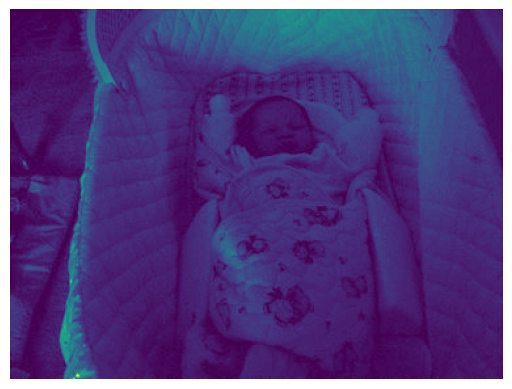


__verbose__: Imops > self.plot_histogram_of_image() @@@ total of pixels is 106032


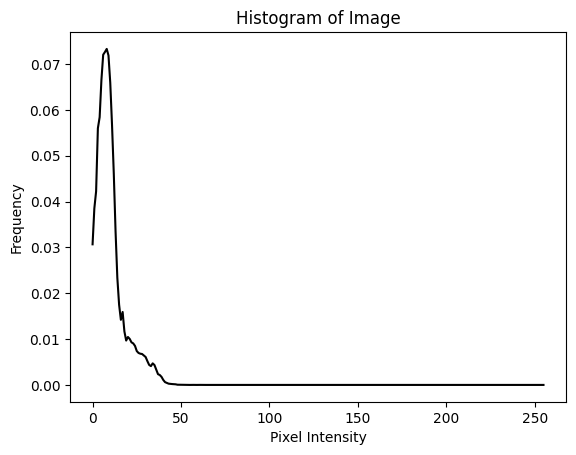


__verbose__: Imops > solbel_image__() @@@ solbel image
__var_name__: return solbel image
 (<class 'numpy.ndarray'>, (282, 376), '212192Bytes')


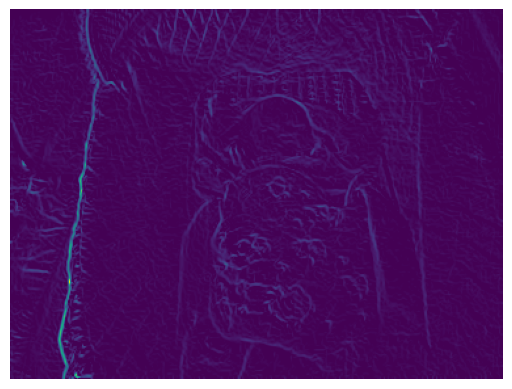


__verbose__: Imops > hog_image__() @@@ hog image
__var_name__: return hog image
 (<class 'numpy.ndarray'>, (282, 376), '848384Bytes')


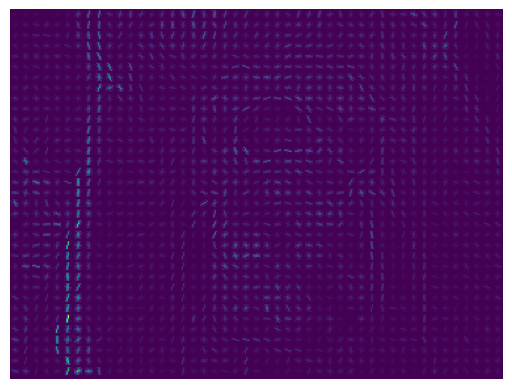


__verbose__: Imops > self.histogram_equali() @@@ apply his equalize None
__var_name__: return equalize image
 (<class 'numpy.ndarray'>, (282, 376), '106160Bytes')


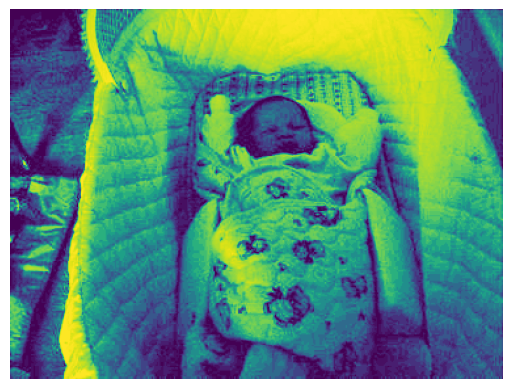


__verbose__: Imops > self.plot_histogram_of_image() @@@ total of pixels is 106032


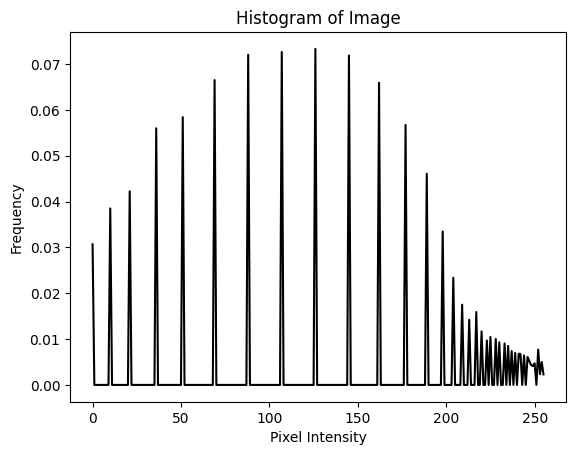

In [9]:
io = Imops()
image = io.load_image_from_file('/kaggle/input/image2/baby.jpg')
io.plot_image(image)

wb_image = io.rgb2wb(image)
io.plot_image(wb_image)

io.plot_histogram_of_image(wb_image)

solbel_image = io.solbel_image_from_image(wb_image)
io.plot_image(solbel_image)

hog_image = io.hog_image_from_image(image)
io.plot_image(hog_image)

equal_image = io.equalize_image(wb_image, tile_size=None)
io.plot_image(equal_image)
io.plot_histogram_of_image(equal_image)